# Basics of PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Parameters
- Batch Size is the number of images used in each training

In [2]:
batch_size = 64

# Datasets
- Download the training and test data from the 'torchvision' library
- The datasets are of object type 'torch.utils.data.Dataset' which stores samples and their corresponding labels.
- The dataset is the FashionMNIST dataset which is a MNIST like data set but of clothing items instead. It's a bit more of a challenge than the original MNIST dataset which is 'too easy'.
- GitHub - https://github.com/zalandoresearch/fashion-mnist
- We are using the PyTorch version which has already been loaded into a Dataset object for us

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# About the data
- The data comprises Gray scale images, each 28x28 pixels in height and width.
- There are 10 types of fashion items in this dataset

![Example](../assets/FashionMNIST.png "Example")

FashionMNIST classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


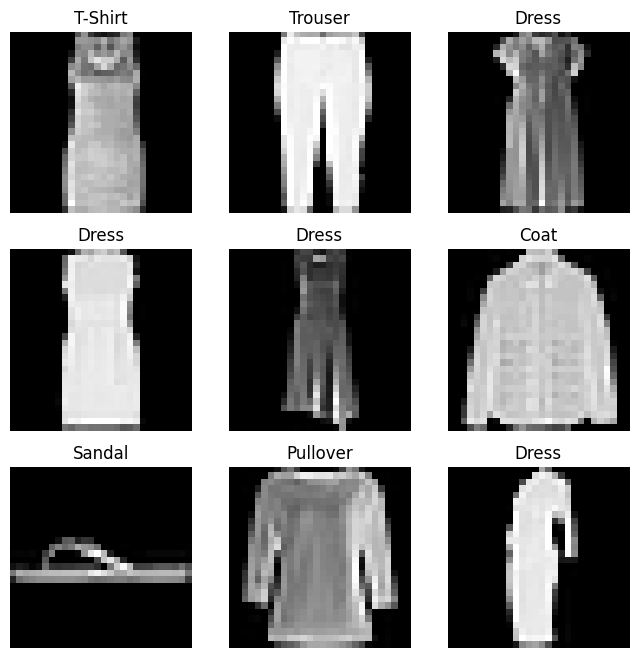

In [4]:
print(f"FashionMNIST classes: {training_data.classes}")

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Dataloader
- The Dataloader (object type -> torch.utils.data.DataLoader) wraps an iterable around Dataset object types
- The Dataloader creates an iterable object for the learning model to use for training. Each item in the iterable is a batch of images and the respective labels for each image in the batch

In [5]:
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")  # X is the batch of images
    print(f"Shape of y: {y.shape} {y.dtype}")  # y is the labels for X
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# The Model

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Optimization of the model

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Training loop

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Test loop

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Model training

In [13]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.294833  [    0/60000]
loss: 2.289836  [ 6400/60000]
loss: 2.260512  [12800/60000]
loss: 2.260544  [19200/60000]
loss: 2.254966  [25600/60000]
loss: 2.216420  [32000/60000]
loss: 2.226854  [38400/60000]
loss: 2.190858  [44800/60000]
loss: 2.190167  [51200/60000]
loss: 2.158533  [57600/60000]
Test Error: 
 Accuracy: 38.8%, Avg loss: 2.154899 

Epoch 2
-------------------------------
loss: 2.161729  [    0/60000]
loss: 2.160594  [ 6400/60000]
loss: 2.094912  [12800/60000]
loss: 2.118875  [19200/60000]
loss: 2.076881  [25600/60000]
loss: 2.011150  [32000/60000]
loss: 2.039764  [38400/60000]
loss: 1.957897  [44800/60000]
loss: 1.969657  [51200/60000]
loss: 1.900868  [57600/60000]
Test Error: 
 Accuracy: 57.6%, Avg loss: 1.895608 

Epoch 3
-------------------------------
loss: 1.921222  [    0/60000]
loss: 1.901566  [ 6400/60000]
loss: 1.775368  [12800/60000]
loss: 1.824684  [19200/60000]
loss: 1.722378  [25600/60000]
loss: 1.664615  [32000/600

# Save the model

In [ ]:
torch.save(model.state_dict(), "../model_saves/model.pth")
print("Saved PyTorch Model State to model.pth")